In [156]:
import dataset_eval
from res_unet import resnet18_UNet
from loss_metric import DiceLoss

import os
import time
import json
import torch
import logging
import numpy as np
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image, ImageOps
import importlib

from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Utils

In [157]:
def return_watershed(image):
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=image)
                     
    return labels

In [158]:
def vis_res(shape, img_tensor, gt_tensor, prob_tensor, pred_tensor, save_path, canon_size=1376):
    H, W = shape
    H = H.numpy()[0]
    W = W.numpy()[0]
    img = img_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):,:]
    print(img.shape)
    gt = gt_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]
    prob = prob_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]
    pred = pred_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]
    labels = return_watershed(pred)
    gt_labels = return_watershed(gt)
    
    print('Num Labels: ')
    print(len(list(set(labels.flatten()))))
    print('Num GT Labels: ')
    print(len(list(set(gt_labels.flatten()))))

    plt.subplot(1,5,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,5,2)
    plt.imshow(gt)
    plt.title('GT')
    plt.subplot(1,5,3)
    plt.imshow(pred)
    plt.title('Pred')
    plt.subplot(1,5,4)
    plt.imshow(labels, cmap=plt.cm.nipy_spectral)
    plt.title('Pred_Labels')
    plt.subplot(1,5,5)
    plt.imshow(gt_labels, cmap=plt.cm.nipy_spectral)
    plt.title('GT_Labels')
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.savefig(save_path, dpi=500)
    plt.close()

# Test

In [159]:
net = resnet18_UNet(pretrained=True, n_class=1, input_size=256)
net.load_state_dict(torch.load("model_49.pt"), strict=True)

<All keys matched successfully>

In [160]:
net.loss = DiceLoss()
net.metric = DiceLoss(get_coefficient=True)
net = net.cuda()

# init dataloader
train_transforms = transforms.Compose([
                        dataset_eval.PadToSquare(),
                        dataset_eval.ToTensor(),
                        dataset_eval.ExtendImageChannel(),
                     ])

# train_transforms = transforms.Compose([
#                         dataset_eval.RandomResizedCrop(size=[256,256]),
#                         dataset_eval.RandomFlip(),
#                         dataset_eval.ToTensor(),
#                         dataset_eval.ExtendImageChannel(),
#                      ])

train_dataset = dataset_eval.MicroscopyDataset("../S-BSST265", "train.txt", transform=train_transforms)
val_dataset = dataset_eval.MicroscopyDataset('../S-BSST265', 'val.txt', transform=train_transforms)

In [161]:
val_dataset.__getitem__(6)[0].shape

torch.Size([3, 1376, 1376])

In [162]:
dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle=False, num_workers=0, drop_last=False)

In [163]:
acc_list = []
images = []
gt_masks = []
predicted_masks = []
pred_labels = []
pred_labels_gt = []
canon_size = 1376
for iter, data in enumerate(dataloader):
    img, mask, shape = data
    H, W = shape
    H = H.numpy()[0]
    W = W.numpy()[0]
    img = img.float().cuda()
    mask = mask.float().cuda()
    pred = net(img)
    acc = net.metric(pred.detach(), mask.detach())
    acc = acc.cpu().numpy() * 2
    
    print()
    print("Iteration %d" % iter)
    print("Accuracy: ")
    print(acc)
    acc_list.append(acc)

    prob = torch.sigmoid(torch.max(pred[0,:,:,:],0)[0])
    res = prob>0.5
    images.append(img[0,:,:,:].permute(1, 2, 0).cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):,:])
    gt_masks.append(mask[0,0,:,:].cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):])
    predicted_masks.append(res.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):])
    pred_labels.append(return_watershed(res.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]))
    pred_labels_gt.append(return_watershed(mask[0,0,:,:].cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]))
    vis_res(shape, img[0,:,:,:].permute(1, 2, 0), mask[0,0,:,:], prob, res, save_path='./test_%d.png' % iter)


Iteration 0
Accuracy: 
0.7001460194587708
(914, 1225, 3)
Num Labels: 
690
Num GT Labels: 
544

Iteration 1
Accuracy: 
0.48829832673072815
(430, 550, 3)
Num Labels: 
276
Num GT Labels: 
195

Iteration 2
Accuracy: 
0.826598584651947
(1024, 1280, 3)
Num Labels: 
371
Num GT Labels: 
93

Iteration 3
Accuracy: 
0.827887773513794
(1024, 1280, 3)
Num Labels: 
352
Num GT Labels: 
87

Iteration 4
Accuracy: 
0.9679539799690247
(1024, 1280, 3)
Num Labels: 
455
Num GT Labels: 
48

Iteration 5
Accuracy: 
0.9611995816230774
(1024, 1280, 3)
Num Labels: 
281
Num GT Labels: 
66

Iteration 6
Accuracy: 
0.7865908145904541
(1024, 1360, 3)
Num Labels: 
172
Num GT Labels: 
117

Iteration 7
Accuracy: 
0.9322893619537354
(1024, 1280, 3)
Num Labels: 
256
Num GT Labels: 
125

Iteration 8
Accuracy: 
0.946703314781189
(1024, 1024, 3)
Num Labels: 
308
Num GT Labels: 
256


In [164]:
np.array(acc_list).mean()

0.8264075285858579

In [165]:
importlib.reload(dataset_eval)
val_dataset_gt = dataset_eval.MicroscopyDataset_EVAL('../S-BSST265', 'val.txt')

In [166]:
dataloader_gt = torch.utils.data.DataLoader(val_dataset_gt, batch_size = 1, shuffle=False, num_workers=0, drop_last=False)

In [167]:
gt_masks_instance = []
for iter, data in enumerate(dataloader_gt):
    mask = data
    gt_masks_instance.append(mask[0,:,:].cpu().numpy())
    print(iter)

0
1
2
3
4
5
6
7
8


In [191]:
image_num = 1

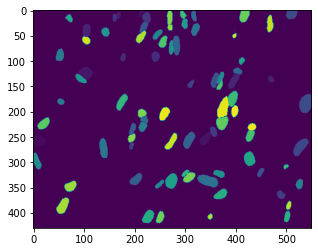

In [192]:
plt.imshow(gt_masks_instance[image_num])

In [193]:
len(list(set(gt_masks_instance[image_num].flatten())))

84

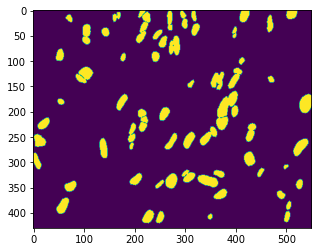

In [194]:
plt.imshow(gt_masks[image_num])

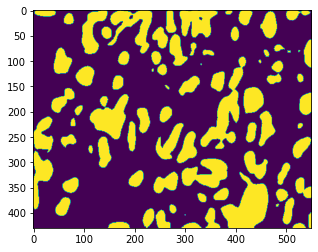

In [195]:
plt.imshow(predicted_masks[image_num])

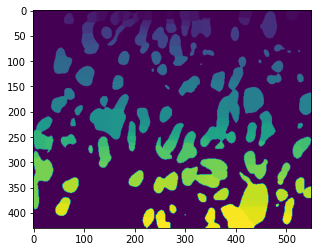

In [196]:
plt.imshow(pred_labels[image_num])

In [197]:
len(list(set(pred_labels[image_num].flatten())))

276

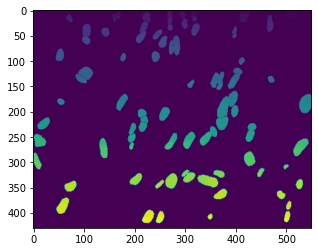

In [198]:
plt.imshow(pred_labels_gt[image_num])

In [199]:
len(list(set(pred_labels_gt[image_num].flatten())))

195

In [200]:
from stardist.matching import matching_dataset
gt_metrics = matching_dataset(gt_masks_instance, pred_labels_gt, thresh=0, show_progress=False)

In [201]:
gt_metrics.mean_true_score

0.6939118190058382

In [202]:
pred_metrics = matching_dataset(gt_masks_instance, pred_labels, thresh=0, show_progress=False)

In [203]:
pred_metrics.mean_true_score

0.5394950099945588

# Expand Labels

In [204]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def expand_labels(label_image, distance=1):
    """Expand labels in label image by ``distance`` pixels without overlapping.
    Given a label image, ``expand_labels`` grows label regions (connected components)
    outwards by up to ``distance`` pixels without overflowing into neighboring regions.
    More specifically, each background pixel that is within Euclidean distance
    of <= ``distance`` pixels of a connected component is assigned the label of that
    connected component.
    Where multiple connected components are within ``distance`` pixels of a background
    pixel, the label value of the closest connected component will be assigned (see
    Notes for the case of multiple labels at equal distance).
    Parameters
    ----------
    label_image : ndarray of dtype int
        label image
    distance : float
        Euclidean distance in pixels by which to grow the labels. Default is one.
    Returns
    -------
    enlarged_labels : ndarray of dtype int
        Labeled array, where all connected regions have been enlarged
    Notes
    -----
    Where labels are spaced more than ``distance`` pixels are apart, this is
    equivalent to a morphological dilation with a disc or hyperball of radius ``distance``.
    However, in contrast to a morphological dilation, ``expand_labels`` will
    not expand a label region into a neighboring region.  
    This implementation of ``expand_labels`` is derived from CellProfiler [1]_, where
    it is known as module "IdentifySecondaryObjects (Distance-N)" [2]_.
    There is an important edge case when a pixel has the same distance to
    multiple regions, as it is not defined which region expands into that
    space. Here, the exact behavior depends on the upstream implementation
    of ``scipy.ndimage.distance_transform_edt``.
    See Also
    --------
    :func:`skimage.measure.label`, :func:`skimage.segmentation.watershed`, :func:`skimage.morphology.dilation`
    References
    ----------
    .. [1] https://cellprofiler.org
    .. [2] https://github.com/CellProfiler/CellProfiler/blob/082930ea95add7b72243a4fa3d39ae5145995e9c/cellprofiler/modules/identifysecondaryobjects.py#L559
    Examples
    --------
    >>> labels = np.array([0, 1, 0, 0, 0, 0, 2])
    >>> expand_labels(labels, distance=1)
    array([1, 1, 1, 0, 0, 2, 2])
    Labels will not overwrite each other:
    >>> expand_labels(labels, distance=3)
    array([1, 1, 1, 1, 2, 2, 2])
    In case of ties, behavior is undefined, but currently resolves to the
    label closest to ``(0,) * ndim`` in lexicographical order.
    >>> labels_tied = np.array([0, 1, 0, 2, 0])
    >>> expand_labels(labels_tied, 1)
    array([1, 1, 1, 2, 2])
    >>> labels2d = np.array(
    ...     [[0, 1, 0, 0],
    ...      [2, 0, 0, 0],
    ...      [0, 3, 0, 0]]
    ... )
    >>> expand_labels(labels2d, 1)
    array([[2, 1, 1, 0],
           [2, 2, 0, 0],
           [2, 3, 3, 0]])
    """

    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [205]:
mask1 = gt_masks_instance[image_num]
mask_pred = predicted_masks[image_num].astype(np.int)

In [206]:
mask2 = mask_pred * mask1

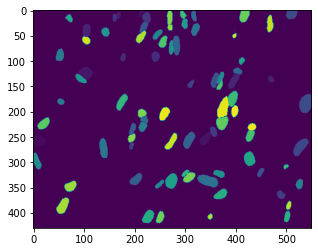

In [207]:
plt.imshow(mask1)

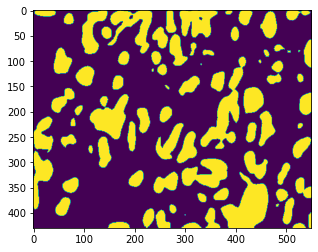

In [208]:
plt.imshow(mask_pred)

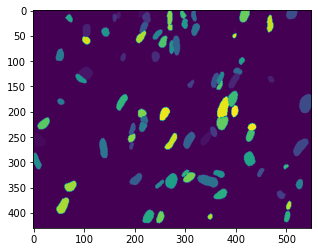

In [209]:
plt.imshow(mask2)

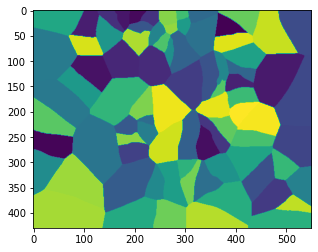

In [210]:
mask3 = expand_labels(mask2,distance=100)
plt.imshow(mask3)

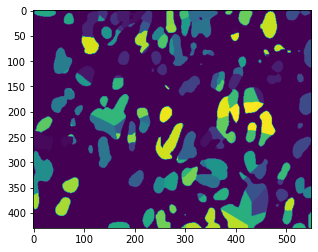

In [211]:
mask4 = mask_pred*mask3
plt.imshow(mask4)

In [212]:
pred_metrics = matching_dataset(gt_masks_instance[image_num], mask4, thresh=0, show_progress=False)

In [213]:
pred_metrics.mean_true_score

0.5701771934930614